# 6.4 Supervised Machine Learning: Regression 

## 1. Imports, Settings, and Loading the Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pyarrow
import warnings
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
project_path = r'C:\Users\cneva\Projects\NBA Shot Analysis'
df = pd.read_csv(os.path.join(project_path,'Datasets','NBA_Shot_Analysis.csv'))
pd.set_option("display.max_columns", None) # pd.reset_option("display.max_columns")
warnings.filterwarnings('ignore', category = FutureWarning) # Suppress seaborn specific future warnings

In [5]:
df.sample(3)

,season,game_id,game_date,arena,city,state,country,player_team_name,player_team_abb,is_home_game,opponent_team_name,opponent_team_abb,player_name,position_group,position,salary,shot_made,action_category,action_type,shot_type,basic_zone,zone_name,zone_range,loc_x,loc_y,shot_distance,quarter,mins_left,secs_left,secs_left_in_quarter,secs_elapsed_in_game
117989,2024,22300225,2023-11-22,Spectrum Center,Charlotte,North Carolina,USA,Washington Wizards,WAS,False,Charlotte Hornets,CHA,Jordan Poole,G,SG,27955357,True,layup,Tip Layup Shot,2PT Field Goal,Restricted Area,Center,Less Than 8 ft.,-0.9,8.75,3,1,7,8,428,248
211372,2024,22300715,2024-02-05,Wells Fargo Center,Philadelphia,Pennsylvania,USA,Philadelphia 76ers,PHI,True,Dallas Mavericks,DAL,Tyrese Maxey,G,PG,4343920,False,shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center,Less Than 8 ft.,-1.7,10.75,5,2,7,55,475,355
217680,2024,22300071,2023-10-25,FedExForum,Memphis,Tennessee,USA,New Orleans Pelicans,NOP,False,Memphis Grizzlies,MEM,Zion Williamson,F,PF,34005250,False,layup,Driving Layup Shot,2PT Field Goal,In The Paint (Non-RA),Left Side,8-16 ft.,4.9,11.95,8,1,9,17,557,137


In [8]:
(df \
 .loc[:,['action_category','shot_made']]
 .groupby('action_category')
 .agg(field_goal_perc = ('shot_made', 'mean'))
)

,field_goal_perc
action_category,
dunk,0.890621
layup,0.568137
shot,0.398591


## 2. Exploring the data - Scatterplot
Hypothesis: Salary and Field Goal % is positvely correlated

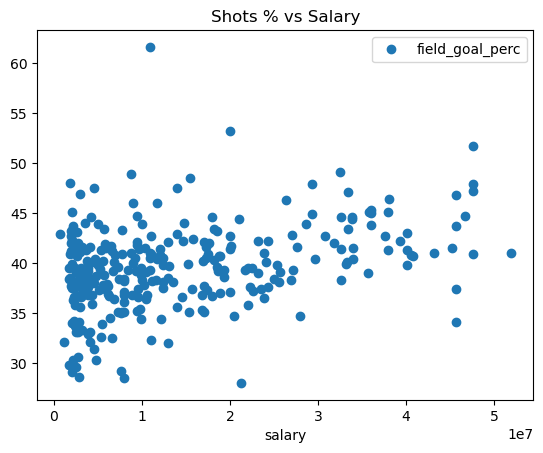

In [9]:
df_plot1 = \
(df \
 .query("action_category == 'shot'")
 .loc[:, ['player_team_name', 'player_name', 'salary', 'position_group', 'shot_made']]
 .groupby(['player_team_name', 'player_name', 'salary', 'position_group']) 
 .agg(
     field_goal_perc = ('shot_made', 'mean'),
     shots_attempted = ('shot_made', 'count')
 )
 .reset_index()
 .assign(
     field_goal_perc = lambda df: df.field_goal_perc.multiply(100).round(1),
     team_total_shots = lambda df: df.groupby('player_team_name')['shots_attempted'].transform('sum'),
     team_shot_perc = lambda df: (df['shots_attempted'] / df['team_total_shots'] * 100).round(1)
 )
 .drop(columns = ['team_total_shots','player_team_name'])
 .query("team_shot_perc > 3") # Filter out players that have < 3% of the teams shots
)

df_plot1.sample(20)

In [ ]:
(df_plot1 \
 .plot(
     x = 'salary',
     y = 'field_goal_perc',
     style = 'o',
     title = 'Field Goal % vs Salary',
 )
)

plt.show()

## 3. Testing Hypothesis

### A. Reshape variables into NumPy arrays 

In [10]:
X = df_plot1.salary.values.reshape(-1, 1)
y = df_plot1.field_goal_perc.values.reshape(-1, 1)

### B. Split the data into training and test 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

### C. Run linear regression

In [11]:
regression = LinearRegression()
regression.fit(X_train, y_train)
y_predicted = regression.predict(X_test)

### D. Plot the regression line on the test set
While the points trend in the same direction as the regression line, many of the points stray a fair distance away

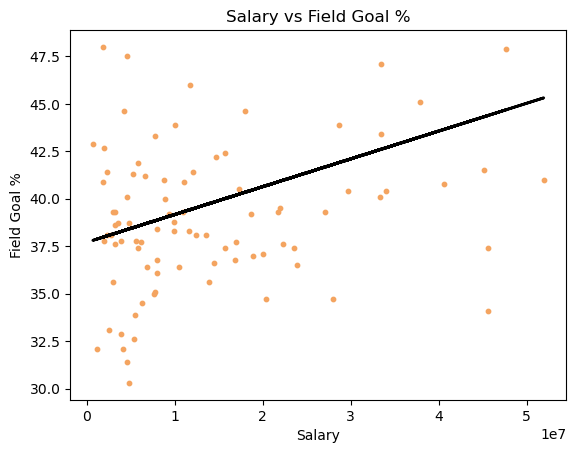

In [12]:
plt.scatter(X_test, y_test, color = 'sandybrown', s = 10)
plt.plot(X_test, y_predicted, color = 'black', linewidth = 2)
plt.title('Salary vs Field Goal %')
plt.xlabel('Salary')
plt.ylabel('Field Goal %')
plt.show()

### E. Model performance statistics 

In [13]:
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)
print('Slope:', regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[1.46537706e-07]]
Mean squared error:  14.744591867779501
R2 score:  -0.05507006294805983


### F. Predicted y values vs actual y values

In [14]:
act_vs_pred = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
act_vs_pred.sample(50)

,Actual,Predicted
2,38.3,39.166072
39,41.2,38.673883
45,42.2,39.863461
67,38.7,38.223060
47,37.6,38.176294
59,41.4,39.469306
36,41.4,38.052501
3,36.4,39.247279
69,36.5,41.208529
43,35.6,39.750198


- The model fits okay with a mean squared error of 14.7 and an R2 score of -0.05
- Many of the points however exists unclustered around the regression line
  
- Some steps were taken, where it makes sense, to reduce the variance and better see if there is a trend between salary and FG %:
    - Players with less than a 3% shots taken of the team were removed to account for one-off plays or scenarios
    - Filtered out dunks which are inherently high shot rate (90%)


In [15]:
y_predicted_train = regression.predict(X_train)
rmse = mean_squared_error(y_train, y_predicted_train)
r2 = r2_score(y_train, y_predicted_train)

print('Slope:', regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[1.46537706e-07]]
Mean squared error:  16.574959061681387
R2 score:  0.16619492983417583


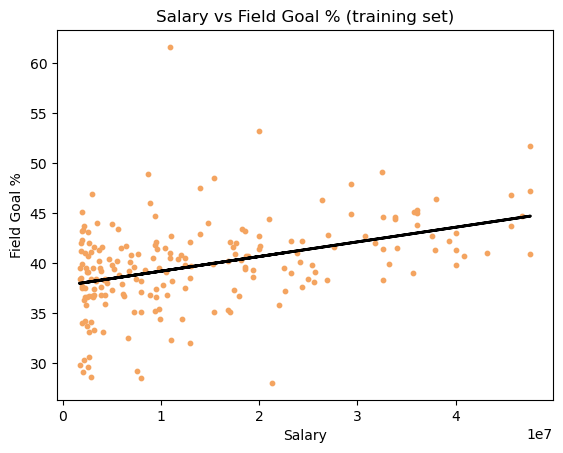

In [16]:
plt.scatter(X_train, y_train, color = 'sandybrown', s = 10)
plt.plot(X_train, y_predicted_train, color = 'black', linewidth = 2)
plt.title('Salary vs Field Goal % (training set)')
plt.xlabel('Salary')
plt.ylabel('Field Goal %')
plt.show()